# <center>PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle</center>

## Постановка задачи

Представьте, что вы работаете дата-сайентистом в компании *Booking*. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Вам поставлена задача создать такую модель.

>В данном проекте мы будем работать с датасетом, в котором содержатся сведения о примерно 515 тыс. отзывов на отели Европы. Модель, которую мы будем обучать, должна предсказывать рейтинг отеля по данным сайта *Booking* на основе имеющихся в датасете данных. Изученные нами навыки разведывательного анализа помогут улучшить модель.

<details>
<summary>Описание признаков в используемых данных</summary>

- *hotel_address* — адрес отеля;
- *review_date* — дата, когда рецензент разместил соответствующий отзыв;
- *average_score* — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- *hotel_name* — название отеля;
- *reviewer_nationality* — страна рецензента;
- *negative_review* — отрицательный отзыв, который рецензент дал отелю;
- *review_total_negative_word_counts* — общее количество слов в отрицательном отзыв;
- *positive_review* — положительный отзыв, который рецензент дал отелю;
- *review_total_positive_word_counts* — общее количество слов в положительном отзыве;
- *total_number_of_reviews_reviewer_has_given* — количество отзывов, которые рецензенты дали в прошлом;
- *total_number_of_reviews* — общее количество действительных отзывов об отеле;
- *tags* — теги, которые рецензент дал отелю;
- *days_since_review* — количество дней между датой проверки и датой очистки;
- *additional_number_of_scoring* — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки;
- *lat* — географическая широта отеля;
- *lng* — географическая долгота отеля.

</details>

## 1. Инициализация и загрузка данных

### 1.1. Загрузка библиотек и инициализация среды выполнения

In [1]:
# Импортируем библиотеки для работы с данными
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Для расчета расстояний на поверхности Земли
from geopy.distance import geodesic  # алгоритм Винсента
from sklearn.neighbors import BallTree  # алгоритм Хаверсина

import ast  # Для работы с литералами
import re  # Для работы с регулярными выражениями

from scipy import stats  # Для тестов на нормальность распределения

# Для семантического анализа отзывов
# import nltk
# nltk.downloader.download('vader_lexicon')  # Единоразовая подгрузка правил
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import category_encoders as ce  # Для работы с кодировщиками

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Установка максимального количества строк
# pd.options.display.max_rows = 800

# Для определения важности числовых и категориальных признаков
from sklearn.feature_selection import f_classif  # ANOVA
from sklearn.feature_selection import chi2  # Хи-квадрат

# Для разделения датасета на трейн и тест (pip install scikit-learn)
from sklearn.model_selection import train_test_split

# Инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
# Инструменты для оценки точности модели (метрики)
from sklearn import metrics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will
# list all files under the input directory
import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that
# gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be
# saved outside of the current session

data\hotels_test.csv
data\hotels_train.csv
data\submission.csv


In [2]:
# Всегда фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42

# Признак визуализации графиков корреляций (долгий расчет)
VISUAL_ANALYZE = 1

# Признак кэширования парсинга тэгов для ускорение расчета модели
CACHED_TAGS = 0

# Признак кэширования подсчета весов комментариев для ускорения расчета модели
CACHED_SCORES = 0

In [3]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

### 1.2. Загрузка данных

In [4]:
# Подгрузим наши данные из соревнования
DATA_DIR = 'data'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv')  # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv')  # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')  # самбмишн

Проанализируем структуру загруженных датасетов и корректность загрузки.

In [5]:
df_train.info()  # Тренировочный (далее - трейн) набор данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()  # Тестовый (далее - тест) набор данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
# Пример выгрузки результатов работы модели (предсказания тестового набора)
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [10]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


## 2. Описательный анализ и очистка данных

### 2.1. Очистка данных от дубликатов

In [11]:
# Проверим на наличие дубликатов (только в трейне, тест не трогаем)
print('Количество дубликатов: {}'.format(df_train[df_train.duplicated()]\
    .shape[0]))

# Удаляем дубликаты в тренировочном датасете
df_train = df_train.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {} строк'\
    .format(df_train.shape[0]))

Количество дубликатов: 307
Размер таблицы после удаления дубликатов: 386496 строк


Для корректной обработки признаков объединяем трейн и тест наборы данных в один датасет.

In [12]:
df_train['sample'] = 1  # Признак маркировки трейна
df_test['sample'] = 0  # Признак маркировки теста
df_test['reviewer_score'] = 0  # В тесте у нас нет значения reviewer_score, заполняем нулями (должны его предсказать)

data = pd.concat([df_train, df_test], ignore_index=True)  # Объединяем датасеты
print('Размер таблицы после объединения датасетов: {} строк'\
    .format(data.shape[0]))

tra_msk = data['sample'] == 1  # Маска для последующего отбора трейн части в расчетах

Размер таблицы после объединения датасетов: 515431 строк


### 2.2. Описательный анализ

Итоговый датасет, очищенный от дубликатов в тренировочной части. Позже тренировочная часть будет разделена в свою очередь на трейн и тест составляющие для обучения модели.

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [14]:
# Текстовые признаки
display(data.describe(include=object))

# Числовые признаки. Исключим целевой признак (в тестовой части равен нулю,
# испортится статистика) и признак принадлежности трейн/тест
display(data.drop(['reviewer_score', 'sample'], axis=1)\
    .describe(include=np.number).round(2))

# Целевой признак
display(data[tra_msk]['reviewer_score'].describe().round(2)\
    .to_frame('Целевой признак'))

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515431,515431,515431,515431,515431,515431,515431,515431
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2584,4789,245165,127816,35924,5101,2584


,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng
count,515431.00,515431.00,515431.00,515431.00,515431.00,515431.00,512163.00,512163.00
mean,498.28,8.40,18.54,2744.26,17.78,7.17,49.44,2.82
std,500.62,0.55,29.69,2317.82,21.80,11.04,3.47,4.58
min,1.00,5.20,0.00,43.00,0.00,1.00,41.33,-0.37
25%,169.00,8.10,2.00,1161.00,5.00,1.00,48.21,-0.14
50%,342.00,8.40,9.00,2134.00,11.00,3.00,51.50,-0.00
75%,660.00,8.80,23.00,3633.00,22.00,8.00,51.52,4.83
max,2682.00,9.80,408.00,16670.00,395.00,355.00,52.40,16.43


,Целевой признак
count,386496.00
mean,8.40
std,1.64
min,2.50
25%,7.50
50%,8.80
75%,9.60
max,10.00


Классификация признаков датасета на количественные (числовые) и категориальные.

Количественные (числовые) признаки:
- *reviewer_score* (целевой признак);
- *average_score*;
- *total_number_of_reviews*;
- *additional_number_of_scoring*;
- *review_total_negative_word_counts*;
- *review_total_positive_word_counts*;
- *total_number_of_reviews_reviewer_has_given*;
- *days_since_review* (в датасете представлен как object, позже будет преобразован в числовой)
- *lat* (измеряется в градусах);
- *lng* (измеряется в градусах)

Категориальные признаки:
- *hotel_address* (номинальный);
- *hotel_name* (номинальный);
- *reviewer_nationality* (номинальный);
- *negative_review* (номинальный);
- *positive_review* (номинальный);
- *tags* (составной признак из нескольких категориальных и числовых признаков, позже будет преобразован)

Специальный признак:
- review_date (дата отзыва, в датасете представлена как object, позже будет преобразована)

In [15]:
# Проверка однозначности соответствия отеля адресу
grp_addr = data.groupby('hotel_name')['hotel_address'].nunique()
hotels_with_multiple_addresses = grp_addr[grp_addr != 1]

# Проверка однозначности соответствия адреса отелю
grp_name = data.groupby('hotel_address')['hotel_name'].nunique()
addresses_with_multiple_hotels = grp_name[grp_name != 1]

# Вывод расхождений
print('Отели с несколькими адресами:')
print(hotels_with_multiple_addresses)
print("\nАдреса, соответствующие нескольким отелям:")
print(addresses_with_multiple_hotels)

Отели с несколькими адресами:
hotel_name
Hotel Regina    3
Name: hotel_address, dtype: int64

Адреса, соответствующие нескольким отелям:
hotel_address
8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom    2
Name: hotel_name, dtype: int64


In [16]:
# Детальная информация о расхождениях
if not hotels_with_multiple_addresses.empty:
    print("\nДетальная информация об отелях с несколькими адресами:")
    for hotel in hotels_with_multiple_addresses.index:
        print(f"Отель: {hotel}")
        print(data[data['hotel_name'] == hotel][['hotel_address', 'lat', 'lng']]\
            .drop_duplicates().to_string())

if not addresses_with_multiple_hotels.empty:
    print("\nДетальная информация об адресах, соответствующих нескольким отелям:")
    for address in addresses_with_multiple_hotels.index:
        print(f"Адрес: {address}")
        print(data[data['hotel_address'] == address][['hotel_name', 'lat', 'lng']]\
            .drop_duplicates().to_string())


Детальная информация об отелях с несколькими адресами:
Отель: Hotel Regina
                                                   hotel_address        lat        lng
479                   Bergara 2 4 Eixample 08002 Barcelona Spain  41.385889   2.168165
1428         Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria  48.216334  16.359554
1566  Via Cesare Correnti 13 Milan City Center 20123 Milan Italy  45.459485   9.179511

Детальная информация об адресах, соответствующих нескольким отелям:
Адрес: 8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom
                               hotel_name        lat       lng
451         The Grand at Trafalgar Square  51.506935 -0.126012
868  Club Quarters Hotel Trafalgar Square  51.506935 -0.126012


В подавляющем большинстве отели и адреса имеют взаимно-однозначное соответствие кроме 2-х случаев:
- международный отель "Hotel Regina" имеет 3 разных адреса (в 3-х разных городах);
- по адресу "8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom" расположено 2 разных отеля, видимо из-за плотной агломерации Лондона.

### 2.3. Очистка данных от пропущенных значений

In [17]:
# Маски пропущенных значений гео-локаций
lat_na_mask = data['lat'].isna()
lng_na_mask = data['lng'].isna()

# Удостоверимся, что в пропущенных значениях гео-локаций маски совпадают (пропущенные значения всегда в парах)
print('Общее количество строк с пропущенным lat:', sum(lat_na_mask))
print('Общее количество строк с пропущенным lng:', sum(lng_na_mask))
print('Общее количество строк с пропущенными lat и lng:',\
    sum(lat_na_mask & lng_na_mask))

# Отобразим уникальные адреса отелей с пропущенными гео-локациями
hotel_address_loc_na_uniq = data[lat_na_mask]['hotel_address'].unique()
print('\nВсего {} уникальных адресов с пропущенными гео-локациями:'\
    .format(len(hotel_address_loc_na_uniq)))
[print(_) for _ in hotel_address_loc_na_uniq];

Общее количество строк с пропущенным lat: 3268
Общее количество строк с пропущенным lng: 3268
Общее количество строк с пропущенными lat и lng: 3268

Всего 17 уникальных адресов с пропущенными гео-локациями:
Savoyenstra e 2 16 Ottakring 1160 Vienna Austria
23 Rue Damr mont 18th arr 75018 Paris France
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria
W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria
4 rue de la P pini re 8th arr 75008 Paris France
Sieveringer Stra e 4 19 D bling 1190 Vienna Austria
Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria
Bail n 4 6 Eixample 08010 Barcelona Spain
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria
Paragonstra e 1 11 Simmering 1110 Vienna Austria
W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria
20 Rue De La Ga t 14th arr 75014 Paris France
Hasenauerstra e 12 19 D bling 1190 Vienna Austria
Sep lveda 180 Eixample 08011 Barcelona Spain
Pau Clar s 122 Eixample 08009 Barcel

In [18]:
# Поскольку поиск 17 уникальных адресов с пропущенными гео-локациями не отрабатывается через внешний сервис GeoPY
# (не находит именно по этим адресам из-за ошибок в них), сформируем список соответствия адресов гео-локациям вручную
loc_na = [
    (48.219555, 16.285566), (48.888860, 2.333190), (48.209402, 16.353446),
    (48.220310, 16.355880), (48.875259, 2.323340), (48.246016, 16.341450),
    (48.213560, 16.379923), (41.391430, 2.177890), (48.220856, 16.366642),
    (48.188769, 16.383773), (48.186829, 16.420716), (48.216705, 16.359820),
    (48.839678, 2.323488), (48.233379, 16.345510), (41.383246, 2.162949),
    (41.392430, 2.167500), (48.209530, 16.351515)
]

# Сформируем словарь соответствия пропущенных адресов гео-локациям
loc_na_dict = {key: value for key, value in zip(hotel_address_loc_na_uniq, loc_na)}

# Заполним строки датасета с пропущенными гео-локациями
data.loc[lat_na_mask, ['lat', 'lng']] = data[lat_na_mask]['hotel_address']\
    .map(loc_na_dict).tolist()

# Удостоверимся, что не осталось строк с пропущенными гео-локациями
sum(data['lat'].isna())

0

### 2.4. Визуальный анализ

In [19]:
# Вспомогательная функция для настройки графиков
def customize_plot(ax, xlabel, ylabel, title, yrotate=False):
    ax.set(xlabel=xlabel, ylabel=ylabel)  # Зададим наименования осей
    ax.set_title(title, fontsize=14)  # Установим размер шрифта
    if yrotate:  # Если задан признак поворота
        # Повернём метки по оси ординат на 90 градусов
        ax.tick_params('y', labelrotation=90)
        # Отцентрируем метки
        [_.set_verticalalignment('center') for _ in ax.get_yticklabels()]


# Функция для принятия решения о нормальности
def decision_normality(p, alpha=0.05):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.3f}. '\
              'Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.3f}. '\
              'Распределение является нормальным'.format(alpha))

### 2.4.1. Визуальный анализ целевого признака

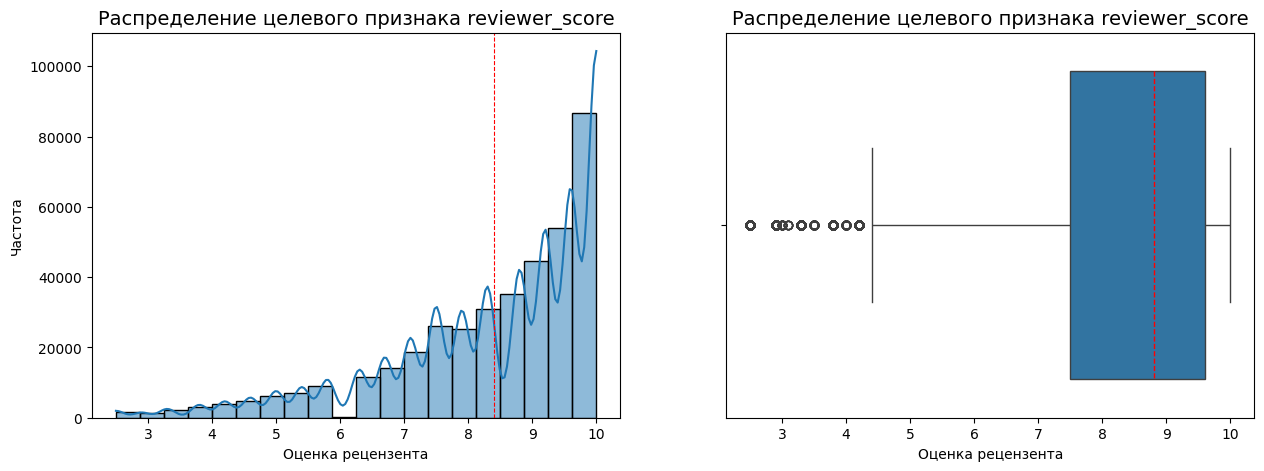

In [20]:
# Создание подграфиков
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График распределения целевого признака
sns.histplot(data[tra_msk]['reviewer_score'], bins=20, kde=True, ax=axes[0])
axes[0].axvline(data[tra_msk]['reviewer_score'].mean(), color='red',
                linestyle='--', linewidth=0.8)
customize_plot(axes[0], 'Оценка рецензента', 'Частота',
               'Распределение целевого признака reviewer_score')

# График распределения целевого признака
sns.boxplot(data[tra_msk]['reviewer_score'], ax=axes[1], orient='h',
            medianprops={"color": "red", "linestyle": '--'})
customize_plot(axes[1], 'Оценка рецензента', '',
               'Распределение целевого признака reviewer_score')

# Отображение графиков
plt.show()

In [21]:
# Статистические параметры признака для описания
reviewer_score_descr = data[tra_msk]['reviewer_score'].describe().round(2)\
    .to_frame('Оценка рецензента')
reviewer_score_descr

,Оценка рецензента
count,386496.00
mean,8.40
std,1.64
min,2.50
25%,7.50
50%,8.80
75%,9.60
max,10.00


In [22]:
# Рассчитаем количество выбросов методом Тьюки
q1_rev = data[tra_msk]['reviewer_score'].quantile(0.25)  # 1-й квартиль
q3_rev = data[tra_msk]['reviewer_score'].quantile(0.75)  # 3-й квартиль
iqr_rev = round(q3_rev - q1_rev, 2)  # Межквартильный размах
# Выберем строки reviewer_score которых < Q1-1.5*IQR
out_lb_rev = data[(tra_msk) & (data['reviewer_score'] < q1_rev - iqr_rev * 1.5)]
print('Количество выбросов ниже границы нижних значений:', out_lb_rev.shape[0])

# # Удалим строки, значения reviewer_score которых < Q1-1.5*IQR
# # Только в трейн выборке, тест не трогаем (иначе собьется последовательность)
# data.drop(out_lb_rev.index, inplace=True)
# data = data.reset_index(drop=True)  # Переиндексируем после удаления строк
# tra_msk = data['sample'] == 1  # Пересоздадим маску, поскольку индексы изменились

Количество выбросов ниже границы нижних значений: 11885


Распределение не является нормальным. Предельные значения: от 2.5 до 10 баллов. В межквартильном размахе (7.5-9.6 баллов) сосредоточено 50% оценок. Медиана: 8.8 баллов, среднее: 8.4 балла. Присутствуют выбросы (меньше нижней границы нормальных значений, равной 4.35 балла) в количестве 11885 оценок.

Избавление от выбросов методом Тьюки сильно ухудшает метрику MAPE на платформе Kaggle, поскольку модель становится недообученной.

### 2.4.2. Визуальный анализ признака average_score

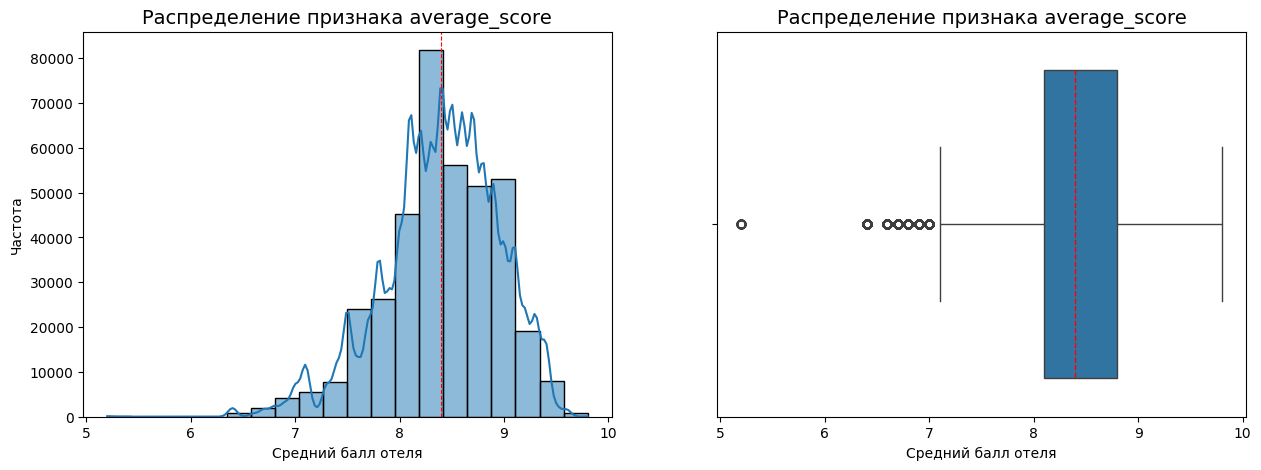

In [23]:
# Создание подграфиков
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График распределения признака average_score
sns.histplot(data[tra_msk]['average_score'], bins=20, kde=True, ax=axes[0])
axes[0].axvline(data[tra_msk]['average_score'].mean(), color='red',
                linestyle='--', linewidth=0.8)
customize_plot(axes[0], 'Средний балл отеля', 'Частота',
               'Распределение признака average_score')

# График распределения признака average_score
sns.boxplot(data[tra_msk]['average_score'], ax=axes[1], orient='h',
            medianprops={"color": "red", "linestyle": '--'})
customize_plot(axes[1], 'Средний балл отеля', '',
               'Распределение признака average_score')

# Отображение графиков
plt.show()

In [24]:
# Статистические параметры признака для описания
average_score_descr = data[tra_msk]['average_score'].describe().round(2)\
    .to_frame('Средний балл отеля')
average_score_descr

,Средний балл отеля
count,386496.00
mean,8.40
std,0.55
min,5.20
25%,8.10
50%,8.40
75%,8.80
max,9.80


С помощью теста **Omnibus Test of Normality** (тест **Шапиро-Уилка** не подходит для выборок > 5000) проверим, имеет ли признак **average_score** нормальное распределение

In [25]:
# Выполним тест на нормальность распределения
decision_normality(stats.normaltest(data['average_score'])[1])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.050. Распределение отлично от нормального


In [26]:
# Рассчитаем количество выбросов методом Тьюки
q1_ave = data[tra_msk]['average_score'].quantile(0.25)  # 1-й квартиль
q3_ave = data[tra_msk]['average_score'].quantile(0.75)  # 3-й квартиль
iqr_ave = round(q3_ave - q1_ave, 2)  # Межквартильный размах
# Выберем строки average_score которых < Q1-1.5*IQR
out_lb_ave = data[(tra_msk) & (data['average_score'] < q1_ave - iqr_ave * 1.5)]
print('Количество выбросов ниже границы нижних значений:', out_lb_ave.shape[0])

# # Удалим строки, значения average_score которых < Q1-1.5*IQR
# # Только в трейн выборке, тест не трогаем (иначе собьется последовательность)
# data.drop(out_lb_ave.index, inplace=True)
# data = data.reset_index(drop=True)  # Переиндексируем после удаления строк
# tra_msk = data['sample'] == 1  # Пересоздадим маску, поскольку количество строк и индексы изменились

Количество выбросов ниже границы нижних значений: 7137


Распределение не является нормальным. Предельные значения: от 5.2 до 9.8 баллов. В межквартильном размахе (8.1-8.8 баллов) сосредоточено 50% оценок. Медиана и среднее: 8.4 балла. Присутствуют выбросы (меньше нижней границы нормальных значений) в количестве 7137 оценок.

Избавление от выбросов методом Тьюки сильно ухудшает метрику MAPE на платформе Kaggle, поскольку модель становится недообученной.

### 2.4.3. Визуальный анализ корреляции числовых признаков с целевым

Проведем предварительную визуальную оценку корреляции числовых признаков с целевым.
>Регрессионная линия помогает видеть направление и силу корреляции между переменными. Положительный наклон линии указывает на положительную корреляцию, а отрицательный наклон - на отрицательную корреляцию

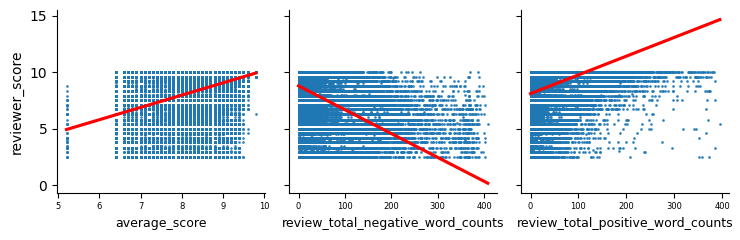

In [27]:
# Сформируем список признаков для отображения
pairplot_col1 = ['average_score', 'review_total_negative_word_counts',
                 'review_total_positive_word_counts']

if VISUAL_ANALYZE:  # Включено ли отображение константой?
    # Отобразим график с регрессионной линией
    fig = sns.pairplot(
        data[tra_msk],
        kind='reg',
        x_vars=pairplot_col1,
        y_vars=['reviewer_score'],
        plot_kws={'scatter_kws':{'s': 1},
                  'line_kws':{'color': 'red'}
        }
    )
    # Настроим размер надписей
    for ax in fig.axes.flat:
        ax.tick_params(axis='x', labelsize=6)
        ax.set_xlabel(ax.get_xlabel(), fontsize=9)
else:
    fig = None

plt.tight_layout()  # Подгоним размеры
plt.show()  # Отобразим график

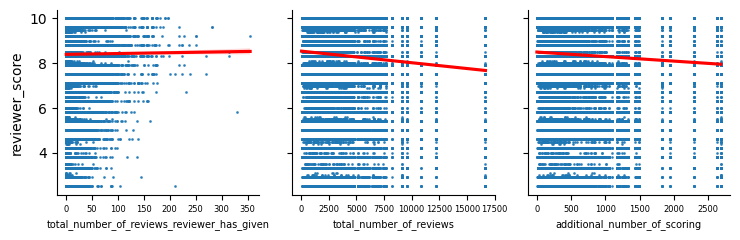

In [28]:
# Сформируем список признаков для отображения
pairplot_col2 = ['total_number_of_reviews_reviewer_has_given',
                 'total_number_of_reviews', 'additional_number_of_scoring']

if VISUAL_ANALYZE:  # Включено ли отображение константой?
    # Отобразим график с регрессионной линией
    fig = sns.pairplot(
        data[tra_msk],
        kind='reg',
        x_vars=pairplot_col2,
        y_vars=['reviewer_score'],
        plot_kws={'scatter_kws':{'s': 1},
                  'line_kws':{'color': 'red'}
        }
    )
    # Настроим размер надписей
    for ax in fig.axes.flat:
        ax.tick_params(axis='x', labelsize=6)
        ax.set_xlabel(ax.get_xlabel(), fontsize=7)
else:
    fig = None

plt.tight_layout()  # Подгоним размеры
plt.show()  # Отобразим график

Графики показывают корреляцию с целевым признаком:
- достаточно сильное влияние признаков average_score, review_total_negative_word_counts и review_total_positive_word_counts;
- малозначительное влияние признаков total_number_of_reviews и additional_number_of_scoring;
- признак total_number_of_reviews_reviewer_has_given практически не оказывает влияния.

## 3. Преобразование и создание новых признаков

### 3.1. Создание признака города (city) и страны (country)

In [29]:
# Получим город и страну из адреса отеля (последние 2 слова кроме UK)
# data[['city', 'country']] = list(data['hotel_address'].apply(lambda x: x.split()[-2:]))
data[['city', 'country']] = data['hotel_address'].str.rsplit(n=2, expand=True)\
    .iloc[:, -2:]

# Исправим город и страну для UK:
# страна занимает 2 слова и город не 2-й, а 5-й с конца
uk_mask = data['country'] == 'Kingdom'
data.loc[uk_mask, 'city'] = data.loc[uk_mask, 'hotel_address'].str\
    .rsplit(n=5, expand=True).iloc[:, -5]
data.loc[uk_mask, 'country'] = 'United Kingdom'

# Проанализизируем значения созданных признаков
data[['city', 'country']].value_counts()

city       country       
London     United Kingdom    262300
Barcelona  Spain              60149
Paris      France             59626
Amsterdam  Netherlands        57212
Vienna     Austria            38938
Milan      Italy              37206
Name: count, dtype: int64

Очевидно, что признаки city и country на 100% мультиколлинеарны. Удалим признак country позже после создания на его основе нового признака иностранца.

### 3.2. Создание признака иностранца (is_foreigner) и очистка от пробелов определенных признаков

In [30]:
# Избавимся от пробелов в начале и конце строк определенных признаков
fea_for_strip = ['reviewer_nationality', 'negative_review', 'positive_review']
data[fea_for_strip] = data[fea_for_strip].apply(lambda _: _.str.strip())

# Создадим новый признак иностранца 
# data['is_foreigner'] = data['reviewer_nationality'].eq(data['country']).map({True: 0, False: 1})
data['is_foreigner'] = np.where(data['reviewer_nationality'] \
    != data['country'], 1, 0)

### 3.3. Создание признака scoring_ratio, преобразование total_number_of_reviews и days_since_review

In [31]:
# Признак оценки качества отеля (позволит понять, сколько людей предпочли
# просто поставить оценку вместо написания отзыва)
data['scoring_ratio'] = data['additional_number_of_scoring'] \
    / data['total_number_of_reviews']

# Прологарифмируем общее количество отзывов, чтобы учесть разницу между
# отелями с большим и малым количеством (очень незначительно улучшает MAPE)
data['total_number_of_reviews'] = np.log(data['total_number_of_reviews'])

# Выделим количество дней с момента отзыва
data['days_since_review'] = data['days_since_review'].apply(
    lambda x: int(x.split()[0]))
data['days_since_review'].describe().round(2)

count    515431.00
mean        354.41
std         208.92
min           0.00
25%         175.00
50%         353.00
75%         527.00
max         730.00
Name: days_since_review, dtype: float64

### 3.4. Преобразование признака даты отзыва (review_date) и создание на его основе новых признаков

Создадим признаки сезона (review_season), года (review_year) и выходного дня (is_review_weekend)

In [32]:
# Преобразуем даты для дальнейшей обработки
data['review_date'] = pd.to_datetime(data['review_date'])

# Создадим новый признак сезона отзыва (позже будет перекодирован)
data['review_season'] = data['review_date'].dt.quarter

# Создадим новый признак месяца в сезоне (квартале) (позже будет перекодирован)
# (ухудшает MAPE с кодировкой на категории и без - отключен)
# data['review_season_month'] = (data['review_date'].dt.month - 1) % 3

# Создадим новый признак года (вместе с нормализацией)
data['review_year'] = data['review_date'].dt.year# - 2015

# Создадим новый признак выходного дня отзыва
data['is_review_weekend'] = np.where(data['review_date'].dt.dayofweek\
    .isin([5, 6]), 1, 0)

### 3.5. Создание признака туристического рейтинга отелей (hotel_distance_rating)

Целесообразно использовать метки гео-локаций для расчета рейтинга отелей до ближайших популярных туристических мест (нужно учесть  не только близость, но и наличие нескольких популярных мест вокруг отеля) в каждом из 6-и городов.

Рассмотрим плюсы и минусы каждого из методов и возможные комбинированные подходы.
1. Метод среднего обратного расстояния до ближайших достопримечательностей.

**Плюсы**:
- Простота реализации: легко рассчитать среднее обратное расстояние;
- Хорошо работает для отелей, которые находятся очень близко к нескольким достопримечательностям, так как оценка возрастает за счет меньших расстояний;
- Подходит для случаев, когда важно выделить отели с минимальным расстоянием до нескольких ключевых мест.
  
**Минусы**:
- Не учитывает количество ближайших достопримечательностей, если они расположены очень близко друг к другу, что снижает точность для туристов, которые хотят быть рядом с большим количеством мест;
- Отели с хорошим расстоянием только до одной или двух достопримечательностей могут получить высокий рейтинг, даже если рядом больше ничего нет.

2. Метод количества соседей / плотности.

**Плюсы**:
-  Учитывает количество достопримечательностей в радиусе заданного расстояния, что более точно отражает насыщенность местами вокруг отеля;
-  Хорошо подходит для оценки туристической привлекательности в районах с высокой плотностью достопримечательностей;
-  Дает более высокий рейтинг отелям с большим количеством ближайших мест, что предпочтительно для туристов.

**Минусы**:
-  Требует определения порога расстояния (радиуса), в пределах которого считаются места, что может быть субъективным и зависящим от города;
-  Меньше внимания уделяется близости (например, разницы между 200 м и 1 км), что может привести к менее точной оценке для тех, кто предпочитает места "в шаговой доступности".

3. Комбинированный метод.

- Этот метод будет учитывать как количество ближайших мест в радиусе (например, до 3 км), так и их среднюю близость;
- Рассчитывается с помощью комбинации двух метрик:
  - Плотность достопримечательностей в радиусе (например, количество мест в радиусе 3 км);
  - Среднее обратное расстояние до достопримечательностей в пределах этого радиуса;
- **Плюсы**: Балансирует между количеством и близостью достопримечательностей, что делает его более универсальным;
- **Минусы**: Немного сложнее реализовать, так как требует объединения нескольких метрик.


**Вывод**

~~- **Комбинированный метод** хорошо подходит для оценки отелей с точки зрения туристов, так как он учитывает и количество мест, и их близость.~~<br>
~~- **Рекомендуемое использование**: Комбинированный метод универсален и может подойти для большинства случаев, особенно для крупных туристических городов.~~<br>
~~- **Преимущества комбинированного подхода**: Этот метод помогает отелям, расположенным рядом с большим количеством популярных мест, а также усиливает рейтинг для отелей с особенно близкими достопримечательностями.~~

Использование комбинированного метода себя не оправдало (ухудшение MAPE, значительно долгий расчет). Используем метод **количества соседей / плотности**.

Предварительно выбраны 10 самых популярных туристических мест в каждом из 6-и городов, которые максимально рассредоточены по городу.

In [33]:
# Данные по популярным местам (10 точек для каждого города)
most_popular_destinations = {
    "London": [
                (51.500710, -0.124592),  # Биг-Бен (Big Ben)
                (51.505149, -0.075585),  # Тауэрский мост (Tower Bridge)
                (51.519291, -0.127149),  # Британский музей (The British Museum)
                (51.501310, -0.141911),  # Букингемский дворец (Buckingham Palace)
                (51.503338, -0.119633),  # Колесо обозрения "Лондонский глаз" (London Eye)
                (51.508216, -0.076531),  # Лондонский Тауэр (Tower of London)
                (51.513754, -0.098343),  # Собор Святого Павла (St Paul’s Cathedral)
                (51.477162, -0.000754),  # Королевская обсерватория в Гринвиче (Royal Observatory Greenwich)
                (51.507923, -0.127920),  # Трафальгарская площадь (Trafalgar Square)
                (51.507596, -0.163862)   # Гайд-парк (Hyde Park)
            ],
    "Barcelona": [
                (41.403706, 2.173504),  # Саграда Фамилия (Sagrada Familia)
                (41.414580, 2.152652),  # Парк Гюэль (Park Güell)
                (41.380300, 2.173900),  # Ла Рамбла (La Rambla)
                (41.368333, 2.150278),  # Монжуик и Фонт Магика (Montjuïc and Font Màgica)
                (41.395514, 2.161669),  # Каса Мила / Ла Педрера (Casa Milà / La Pedrera)
                (41.383333, 2.175000),  # Готический квартал / Барри Готик (Gothic Quarter / Barri Gòtic)
                (41.380893, 2.122835),  # Камп Ноу / Стадион ФК Барселона (Camp Nou / FC Barcelona Stadium)
                (41.381667, 2.174444),  # Пласа Реаль (Plaça Reial)
                (41.387222, 2.185556),  # Парк Сьютаделья (Parc de la Ciutadella)
                (41.378333, 2.184167)   # Порт Велл (Port Vell)
            ],
    "Paris": [
                (48.858370, 2.294481),  # Эйфелева Башня (Eiffel Tower)
                (48.863214, 2.294481),  # Луврский музей (Louvre Museum)
                (48.853212, 2.349802),  # Собор Нотр-Дам (Notre-Dame Cathedral)
                (48.873815, 2.294481),  # Арка Триумфа (Arc de Triomphe)
                (48.886437, 2.343104),  # Монмартр и Собор Сакре-Кёр (Montmartre and Sacré-Cœur)
                (48.863214, 2.326500),  # Сады Тюильри (Tuileries Gardens)
                (48.865369, 2.322225),  # Площадь Согласия (Place de la Concorde)
                (48.859301, 2.326500),  # Музей Орсе (Musée d'Orsay)
                (48.848301, 2.343104),  # Латинский Квартал (Latin Quarter)
                (48.846699, 2.336899)   # Сады Люксембург (Luxembourg Gardens)
            ],
    "Amsterdam": [
                (52.359861, 4.884145),  # Рийксмузеум (Rijksmuseum)
                (52.523333, 4.884167),  # Дом Анны Франк (Anne Frank House)
                (52.356667, 4.866667),  # Вонделпарк (Vondelpark)
                (52.358333, 4.881111),  # Музей Ван Гога (Van Gogh Museum)
                (52.373333, 4.890833),  # Королевский дворец (Royal Palace of Amsterdam)
                (52.373889, 4.894444),  # Старая церковь (Oude Kerk)
                (52.358056, 4.879444),  # Музей Стеделик (Stedelijk Museum)
                (52.366667, 4.916667),  # Зоопарк Артис (Artis Royal Zoo)
                (52.363889, 4.883333),  # Лейдсеплейн (Leidseplein)
                (52.373333, 4.891111)   # Бегинхоф (Begijnhof)
            ],
    "Vienna": [
                (48.184864, 16.312241),  # Шёнбруннский дворец (Schönbrunn Palace)
                (48.177206, 16.304059),  # Зоопарк Шёнбрунн (Tiergarten Schönbrunn)
                (48.205532, 16.364763),  # Хофбург (Hofburg)
                (48.203335, 16.361694),  # Кунстхисторишес Музеум (Kunsthistorisches Museum)
                (48.191114, 16.380234),  # Бельведер (Belvedere)
                (48.208174, 16.373819),  # Собор Святого Стефана (St. Stephen's Cathedral)
                (48.203555, 16.368460),  # Венская государственная опера (Staatsoper)
                (48.216077, 16.396261),  # Гигантское колесо обозрения (Riesenrad) в Пратере
                (48.249502, 16.410834),  # Дунайская башня (Donauturm)
                (48.206764, 16.387700)   # Кунстхаус Вена (KunstHausWien)
            ],
    "Milan": [
                (45.464211, 9.191383),  # Миланский собор (Duomo di Milano)
                (45.465817, 9.191383),  # Галерея Витторио Эмануэле II (Galleria Vittorio Emanuele II)
                (45.466944, 9.183056),  # Замок Сфорца (Castello Sforzesco)
                (45.473611, 9.173056),  # Парк Семпионе (Parco Sempione)
                (45.467500, 9.189167),  # Театр Ла Скала (Teatro alla Scala)
                (45.464167, 9.172222),  # Последняя Вечеря Леонардо да Винчи (The Last Supper)
                (45.457778, 9.176389),  # Каналы Навигли (Navigli)
                (45.468056, 9.188333),  # Пинакотека Брера (Pinacoteca di Brera)
                (45.459167, 9.174444),  # Базилика Сан Амброджо (Basilica di Sant'Ambrogio)
                (45.480556, 9.191389)   # ПортаНуова и Корсо Комо (Porta Nuova and Corso Como)
            ]
}

# Установка радиуса поиска ближайших отелей в километрах
RADIUS_KM = 3

# Построение деревьев достопримечательностей для BallTree в контексте города
balltree_destinations = {city: BallTree(np.radians(destinations), metric=\
    'haversine') for city, destinations in most_popular_destinations.items()}

# Функция для расчета рейтинга с использованием BallTree
def calculate_combined_rating(row, tree, destinations, radius_km=RADIUS_KM):
    # Преобразование координат отеля в радианы
    hotel_location = np.radians([row['lat'], row['lng']])

    # Преобразование радиуса из километров в радианы
    radius_radians = radius_km / 6371

    # Поиск индексов достопримечательностей в радиусе
    nearby_indices = tree.query_radius([hotel_location], r=radius_radians)[0]
    # display(nearby_indices)

    # Плотность: количество достопримечательностей в заданном радиусе
    density = len(nearby_indices)
    
    # Если есть ближайшие места, считаем среднее от обратного расстояния до каждого из найденных мест
    # if nearby_indices.size > 0:
    #     distances = [geodesic(hotel_location, destinations[i]).kilometers for i in nearby_indices]
    #     avg_inverse_distance = np.mean([1 / d if d != 0 else float('inf') for d in distances])
    # else:
    #     avg_inverse_distance = 0
    
    # Отключим комбинированный метод (комментирование строк выше)
    # используем метод количества соседей / плотности
    avg_inverse_distance = 1

    # Комбинированный рейтинг: произведение плотности на среднее обратное расстояние
    combined_rating = density * avg_inverse_distance
    return combined_rating

# Применение функции к каждой строке (ухудшает MAPE, отключено)
# data['hotel_distance_rating'] = data.apply(
#     lambda _:
#     calculate_combined_rating(_, balltree_destinations[_['city']],
#         most_popular_destinations[_['city']]),
#     axis=1
# )

>Справочно. Библиотека geopy.distance использует алгоритм Винсента (Vincenty's formulae), который является одним из наиболее точных алгоритмов для расчета расстояний на поверхности Земли. Этот алгоритм учитывает форму Земли, которая не является идеальной сферой, а скорее эллипсоидом. С другой стороны, библиотека scikit-learn, которая используется для построения BallTree, использует алгоритм Хаверсина (Haversine formula) для расчета расстояний на поверхности Земли. Этот алгоритм является более простым и быстрым, но менее точным, чем алгоритм Винсента.

Поскольку создание признака hotel_distance_rating ухудшает метрику MAPE, не включаем его в результирующий набор.

In [34]:
# Избавимся от лишних признаков, которые более не нужны: 
# review_date, country (на 100% мультиколлинеарен с city)
# и lat/lng (на основе их создан новый признак hotel_distance_rating)
data.drop(['review_date', 'country', 'lat', 'lng'], axis=1, inplace=True)

### 3.6. Создание новых признаков из tags

Проанализированы наиболее часто используемые тэги и созданы паттерны для регулярных выражений

In [35]:
# Функция для создания признаков из tags
def create_features(row):
    # Сформируем список из тэгов с обрезкой пробелов по краям
    tags = [tag.strip() for tag in ast.literal_eval(row['tags'])]

    features = {
        'is_leisure': int('Leisure trip' in tags),
        'is_couple': int('Couple' in tags),
        'is_solo': int('Solo traveler' in tags),
        'is_business': int('Business trip' in tags),
        'is_group': int('Group' in tags),
        'is_family': int(any(tag.startswith('Family') for tag in tags)),
        'tags_count': len(tags)
    }

    # Распарсим количество ночей с помощью регулярного выражения с
    # захватывающей группой
    features['stayed_nights'] = next((int(_.group(1)) for tag in tags if (
        _ := re.search(r'Stayed (\d+) (?:night|nights)', tag))), 0)

    # Создание 3-х признаков конфигурации кроватей: одиночные, двойные или
    # гибкой конфигурации
    features['is_single_bed'], features['is_double_bed'], \
        features['is_flexible_bed'] = 0, 0, 0
    if any(re.search(r'\b(Double|Double Room|Double Bed|Double Beds|King|'\
    r'Queen)\s(or|Twin|and)\b', tag) for tag in tags):
        features['is_flexible_bed'] = 1  # Признак гибкой конфигурации кроватей
    elif any(re.search(r'\b(Double Room|Double Bed|Double Beds|King|king|'\
    r'kingsize|Queen)(?!\s(or|Twin|and))\b', tag) for tag in tags):
        # Признак двуспальной кровати с исключением вариативных или составных
        # конфигураций (используем отрицательное look-ahead условие)
        features['is_double_bed'] = 1
    else:
        features['is_single_bed'] = 1  # Признак одиночной(ых) кровати(ей)

    # Количество комнат (по умолчанию 1 комната, если в тэгах не найдена
    # классификация)
    features['rooms_count'] = next(
        (int(_.group(1)) if _.group(1) else {
            'Single Room': 1,
            'Studio Suite': 1,
            'Suite': 2,
            'Triple': 3,
            'Quadruple': 4,
            'Quintuple': 5,
            'Sextuple': 6
        }.get(_.group(0)) for tag in tags if (_ := re.search(
            r'(\d+) rooms|Single Room|Studio Suite|Suite|Triple|Quadruple|'\
                r'Quintuple|Sextuple',
            tag))
        ),
        1
    )

    # Классы номеров по комфортности
    features['cls_room_eco'], features['cls_room_dlx'], \
        features['cls_room_sup'] = 0, 0, 0
    if any(re.search(r'\b(Luxury|Superior|Premier|Executive|Club|Hilton|'\
    r'Dorsett)\b', tag) for tag in tags):
        features['cls_room_sup'] = 1  # Класс повышенной комфортности
    elif any(re.search(r'\b(Modern|Comfort|Cosy|Deluxe|Large|Junior Suite|'\
    r'Suite)\b', tag) for tag in tags):
        features['cls_room_dlx'] = 1  # Средний класс
    else:
        features['cls_room_eco'] = 1  # Экономный класс

    return pd.Series(features)


if CACHED_TAGS:
    # Кэширование включено, загрузим датафрейм из файла
    feat_tags = pd.read_csv('tags_parsed.csv')
else:
    # Применение функции к каждой строке в DataFrame
    feat_tags = data.apply(create_features, axis=1)
    # Сохраним датафрейм в файл для кэширования
    feat_tags.to_csv('tags_parsed.csv', index=False)

# Объединение исходных данных с новыми признаками
data = pd.concat([data, feat_tags], axis=1)

Проведем визуальный анализ созданных признаков с целевым

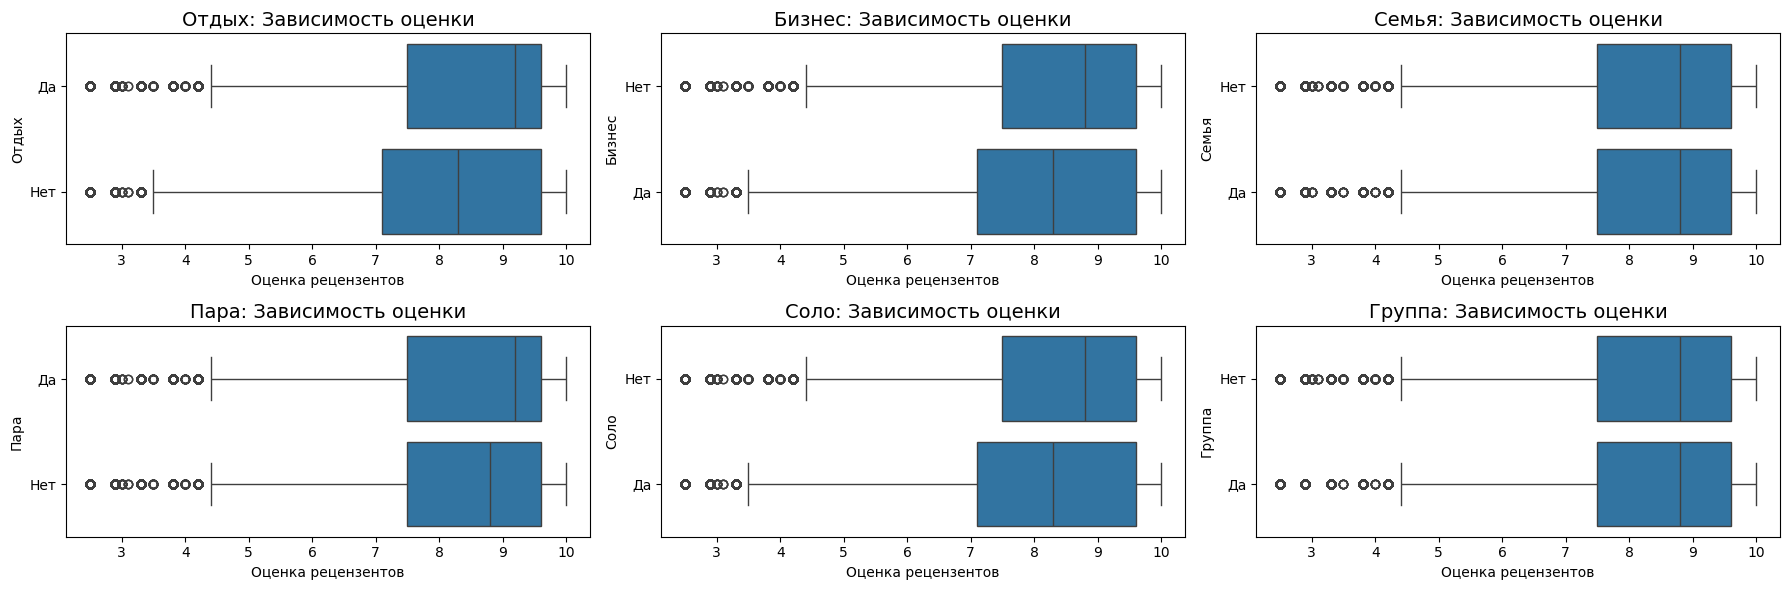

In [36]:
# Сформируем словарь созданных признаков для отображения графиков
trip_types = {
    'is_leisure': 'Отдых',
    'is_business': 'Бизнес',
    'is_family': 'Семья',
    'is_couple': 'Пара',
    'is_solo': 'Соло',
    'is_group': 'Группа'
}

# Зададим конфигурацию графиков и размеры
fig, axes = plt.subplots(2, 3, figsize=(18, 6))

# Пройдемся по словарю и рассчитаем графики
for i, (trip, trip_label) in enumerate(trip_types.items()):
    row, col = divmod(i, 3)
    sns.boxplot(y=data[tra_msk][trip].map({0: 'Нет', 1: 'Да'}), orient='h',
        x=data[tra_msk]['reviewer_score'], ax=axes[row][col])
    axes[row][col].set_title(f'{trip_label}: Зависимость оценки', fontsize=14)
    axes[row][col].set_xlabel('Оценка рецензентов')
    axes[row][col].set_ylabel(trip_label)

plt.tight_layout()  # Подгоним размеры
plt.show()  # Отобразим график

По графикам видно, что признаки "Отдых" и "Бизнес" практически взаимоисключающие (кроме медианы). Позже проверим это при анализе на мультиколлинеарность.
Признак "Семья" и "Группа" практически не оказывает никакого влияния на целевой признак, у признака "Пара" медиана чуть выше при практически равном межквартильном размахе. Везде присутствует большое количество выбросов и в целом можно считать, что в связи с незначительными отличиями в распределениях, все признаки этой группы мало оказывают влияние на целевой признак.

### 3.7. Преобразование признаков негативных и позитивных комментариев и создание на их основе новых признаков

Вручную проанализированы и отобраны наиболее используемые комментарии командами:
```
# display(data['negative_review'].value_counts().head(500))
# display(data['positive_review'].value_counts().head(800))
```

Сформировано по 2 списка (на отрицательные и положительные комментарии):
- список неинформативных фраз, которые не несут никакой смысловой нагрузки;
- противоположные по смыслу комментарии

In [37]:
non_informative_phrases_neg = [
    'as above', 'can t fault anything', 'can t fault it',
    'can t think of a thing', 'can t think of any',
    'can t think of anything', 'can t think of anything i didn t like',
    'can t think of anything we didn t like', 'cannot think of anything',
    'cant think of anything', 'could not fault anything',
    'going home', 'i', 'i can t think of anything',
    'i have no complaints', 'n a', 'na', 'nada', 'nil',
    'nithing', 'no', 'no bad experience', 'no bad experiences',
    'no comment', 'no comments', 'no complains', 'no complaints',
    'no complaints at all', 'no complaints whatsoever',
    'no dislikes', 'no faults', 'no issues', 'no issues at all',
    'no negative', 'no negative comments', 'no negatives',
    'no problems', 'no problems at all', 'no thing', 'non',
    'none', 'nope', 'not a thing', 'not one thing', 'nothin',
    'nothing', 'nothing at all', 'nothing bad', 'nothing bad at all',
    'nothing bad to report', 'nothing bad to say',
    'nothing comes to mind', 'nothing i can think of',
    'nothing i did not like', 'nothing i didn t like',
    'nothing in particular', 'nothing much', 'nothing negative',
    'nothing negative to say', 'nothing not to like',
    'nothing of note', 'nothing particular', 'nothing really',
    'nothing special', 'nothing specific', 'nothing springs to mind',
    'nothing that i can think of', 'nothing that i didn t like',
    'nothing to add', 'nothing to complain', 'nothing to complain about',
    'nothing to complain about at all', 'nothing to dislike',
    'nothing to fault', 'nothing to mention', 'nothing to not like',
    'nothing to note', 'nothing to report', 'nothing to say',
    'nothing was bad', 'nothing we didn t like',
    'nothing worth mentioning', 'nothings', 'nothinh', 'noting',
    'really nothing', 'see above', 'the rain', 'the weather',
    'there is nothing to dislike', 'there was nothing i did not like',
    'there was nothing i didn t like',
    'there was nothing not to like', 'there was nothing that i didn t like',
    'there was nothing that we didn t like', 'there was nothing to dislike',
    'there was nothing we did not like', 'there was nothing we didn t like',
    'there wasn t anything i didn t like', 'there wasn t anything not to like',
    'there wasn t anything we didn t like', 'weather', 'zero'
]

positive_in_negative = [
    'absolutely nothing', 'all fine', 'all good', 'all great', 'all ok',
    'all perfect', 'all very good', 'all was excellent', 'all was fine',
    'all was good', 'all was great', 'all was ok', 'all was perfect',
    'couldn t fault anything', 'couldn t fault it', 'couldn t fault the hotel',
    'everything good', 'everything perfect', 'everything was excellent',
    'everything was fantastic', 'everything was fine', 'everything was good',
    'everything was great', 'everything was ok', 'everything was perfect',
    'everything was very good', 'everything was wonderful',
    'happy with everything', 'i liked everything', 'having to go home',
    'having to leave', 'i liked it all', 'i loved everything', 'i loved it all',
    'it was all good', 'it was all great', 'it was perfect', 'liked everything',
    'liked it all', 'loved everything', 'loved it all', 'nothing all good',
    'nothing all great', 'nothing all perfect', 'nothing all was good',
    'nothing all was great', 'nothing all was perfect',
    'nothing everything was excellent', 'nothing everything was good',
    'nothing everything was great', 'nothing everything was perfect',
    'nothing it was all good', 'nothing it was all great',
    'nothing it was excellent', 'nothing it was great', 'nothing it was perfect',
    'nothing loved it', 'perfect', 'that i couldn t stay longer',
    'that we couldn t stay longer', 'was all good', 'we liked everything',
    'we liked it all', 'we loved everything', 'we loved it all',
    'wish i could have stayed longer'
]

non_informative_phrases_pos = [
    'nothing', 'nothing special', 'nothing really', 'n a', 'none', 'no',
    'nothing much', 'nothing in particular', 'no thing'
]

negative_in_positive = [
    'no positive', 'nothing at all', 'absolutely nothing', 'almost nothing'
]

# Очистим негативные комментарии от неинформативных значений
data['negative_review'] = data['negative_review'].apply(
    lambda x: '' if x.lower() in non_informative_phrases_neg else x)
# Установим признак наличия позитивных комментариев в негаивных
data['pos_in_neg'] = data['negative_review'].apply(
    lambda x: 1 if x.lower() in positive_in_negative else 0)
# Очистим негативные комментарии от позитивных
data['negative_review'] = data['negative_review'].apply(
    lambda x: '' if x.lower() in positive_in_negative else x)
# Очистим позитивные комментарии от неинформативных значений
data['positive_review'] = data['positive_review'].apply(
    lambda x: '' if x.lower() in non_informative_phrases_pos else x)
# Установим признак наличия негативных комментариев в позитивных
data['neg_in_pos'] = data['positive_review'].apply(
    lambda x: 1 if x.lower() in negative_in_positive else 0)
# Очистим позитивные комментарии от негативных
data['positive_review'] = data['positive_review'].apply(
    lambda x: '' if x.lower() in negative_in_positive else x)

In [38]:
# Пересчет количества слов для негативных и позитивных комментариев
# (анализ показал, что в существующих признаках количество слов ошибочно)
data['review_total_negative_word_counts'] = data['negative_review']\
    .apply(lambda x: len(x.split()))
data['review_total_positive_word_counts'] = data['positive_review']\
    .apply(lambda x: len(x.split()))

# Новый признак разницы количества слов в положительных и 
# отрицательных комментариях
data['positive_negative_word_diff'] = data['review_total_positive_word_counts']\
    - data['review_total_negative_word_counts']

In [39]:
# Инициализируем объект семантического анализатора
sent_analyzer = SentimentIntensityAnalyzer()

# Функция для расчета объединенного, позитивного и негативного рейтингов
# комментариев строки
def calculate_polarity_diff(row):
    # Рассчитаем рейтинги для позитивного комментария
    positive_scores = sent_analyzer.polarity_scores(row['positive_review'])
    # Рассчитаем рейтинги для негативного комментария
    negative_scores = sent_analyzer.polarity_scores(row['negative_review'])
    return (
        positive_scores['compound'] + negative_scores['compound'],
        positive_scores['pos'],
        negative_scores['neg']
    )


# Определим список новых признаков эмоциональной окраски позитивного и
# негативного комментариев
polarity_feats = ['polarity_score_compound_diff', 'polarity_score_pos', 
                  'polarity_score_neg']
feat_scores = pd.DataFrame()

if CACHED_SCORES:
    # Кэширование включено, загрузим датафрейм из файла
    feat_scores = pd.read_csv('scores_cached.csv')
else:
    # Применение функции к каждой строке в DataFrame
    feat_scores[polarity_feats] = round(data.apply(calculate_polarity_diff, 
        axis=1, result_type='expand'), 4)
    # Сохраним датафрейм в файл для кэширования
    feat_scores.to_csv('scores_cached.csv', index=False)

# Объединение исходных данных с новыми признаками
data = pd.concat([data, feat_scores], axis=1)

In [40]:
# raise SystemExit("Stop right there!")  # Остановка выполнения для отладки

## 4. Кодирование признаков

In [41]:
# Перекодируем признак города
# Создаем объект OneHotEncoder, cols - имя столбца
ohe_encoder = ce.OneHotEncoder(cols=['city'])
# Применяем трансформацию к столбцу
type_ohe = ohe_encoder.fit_transform(data['city'])
# Удалим старый признак 'city'
data.drop('city', axis=1,  inplace=True)
# Добавим новый трансформированный признак 'city'
data = pd.concat([data, type_ohe], axis=1)

# # Перекодируем признак года (ухудшает MAPE, отключено)
# ohe_encoder = ce.OneHotEncoder(cols=['review_year'])  # Создаем объект OneHotEncoder, cols - имя столбца
# type_ohe = ohe_encoder.fit_transform(data['review_year'])  # Применяем трансформацию к столбцу
# data.drop('review_year', axis=1,  inplace=True)  # Удалим старый признак 'review_year'
# data = pd.concat([data, type_ohe], axis=1)  # Добавим новый трансформированный признак 'review_year'

# # Перекодируем признак месяца в квартале (создание признака не оправдано, отключено)
# ohe_encoder = ce.OneHotEncoder(cols=['review_season_month'])  # Создаем объект OneHotEncoder, cols - имя столбца
# type_ohe = ohe_encoder.fit_transform(data['review_season_month'])  # Применяем трансформацию к столбцу
# data.drop('review_season_month', axis=1,  inplace=True)  # Удалим старый признак 'review_season_month'
# data = pd.concat([data, type_ohe], axis=1)  # Добавим новый трансформированный признак 'review_season_month'

# Перекодируем признак сезона ревью
# Создаем объект OneHotEncoder, cols - имя столбца
ohe_encoder = ce.OneHotEncoder(cols=['review_season'])
# Применяем трансформацию к столбцу
type_ohe = ohe_encoder.fit_transform(data['review_season'])
# Удалим старый признак 'review_season'
data.drop('review_season', axis=1,  inplace=True)
# Добавим новый трансформированный признак 'review_season'
data = pd.concat([data, type_ohe], axis=1)

# Перекодируем признак национальности ревьювера
# Создаем объект BinaryEncoder, cols - имя столбца
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
# Применяем трансформацию к столбцу
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
# Удалим старый признак 'reviewer_nationality'
data.drop('reviewer_nationality', axis=1, inplace=True)
# Добавим новый трансформированный признак 'reviewer_nationality'
data = pd.concat([data, type_bin], axis=1)

# Перекодируем количество проведенных ночей на категории (ухудшает MAPE, отключено)
# data['stayed_nights'] = pd.cut(data['stayed_nights'], bins=[0, 5, 10, 15, 20, 25, 31], labels=[0, 1, 2, 3, 4, 5], include_lowest=True)
# data['stayed_nights'] = data['stayed_nights'].apply(lambda x: x if x<6 else 6)

# Перекодируем количество комнат на категории (нумерацию изменим с нуля)
data['rooms_count'] = data['rooms_count'].apply(
    lambda x: x - 1 if x < 3 else 2)

# Перекодирование на категории (ухудшает MAPE, отключено)
# data['total_number_of_reviews_reviewer_has_given'] = pd.cut(data['total_number_of_reviews_reviewer_has_given'],
#     bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 355], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], include_lowest=True)
# data['total_number_of_reviews_reviewer_has_given'].value_counts()

In [42]:
# Удалим исходные признаки с типом object, которые уже обработаны
obj_col = [_ for _ in data.columns if data[_].dtypes == 'object']
data.drop(obj_col, axis=1, inplace=True)

## 5. Анализ мультиколлинеарности

In [43]:
# Определим признаки для анализа мультиколлинеарности
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 52 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  float64
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   reviewer_score                              515431 non-null  float64
 7   days_since_review                           515431 non-null  int64  
 8   sample                                      515431 non-null  int64  
 9   is_foreigner                                515431 non-null  int64  
 

In [44]:
# Количество уникальных значений каждого признака
data.nunique(dropna=False)

additional_number_of_scoring                    480
average_score                                    34
review_total_negative_word_counts               401
total_number_of_reviews                        1142
review_total_positive_word_counts               365
total_number_of_reviews_reviewer_has_given      198
reviewer_score                                   38
days_since_review                               731
sample                                            2
is_foreigner                                      2
scoring_ratio                                  1459
review_year                                       3
is_review_weekend                                 2
is_leisure                                        2
is_couple                                         2
is_solo                                           2
is_business                                       2
is_group                                          2
is_family                                         2
tags_count  

In [45]:
# Числовые признаки (целевой признак не включаем)
# Добавим признаки pos_in_neg и neg_in_pos, поскольку они должны коррелировать
# со схожими по смыслу признаками семантического анализа, являющиеся числовыми.
# Дополнительно добавим признак review_year, поскольку days_since_review
# по смыслу должен с ним коррелировать
num_cols = [
    'average_score',
    'scoring_ratio',
    'additional_number_of_scoring',
    'total_number_of_reviews',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review',
    'stayed_nights',
    'positive_negative_word_diff',
    'polarity_score_compound_diff',
    'polarity_score_pos',
    'polarity_score_neg',
    'pos_in_neg',  # Categorical
    'neg_in_pos',  # Categorical
    'review_year'  # Ordinal
]

# Категориальные признаки (sample не включаем)
cat_cols = [
    'is_foreigner',
    'review_year',  # Ordinal
    'is_review_weekend',
    'is_leisure',
    'is_couple',
    'is_solo',
    'is_business',
    'is_group',
    'is_family',
    'tags_count',  # Ordinal
    'is_single_bed',
    'is_double_bed',
    'is_flexible_bed',
    'rooms_count',  # Ordinal
    'cls_room_eco',
    'cls_room_dlx',
    'cls_room_sup',
    'pos_in_neg',
    'neg_in_pos',
    'city_1',
    'city_2',
    'city_3',
    'city_4',
    'city_5',
    'city_6',
    'review_season_1',
    'review_season_2',
    'review_season_3',
    'review_season_4',
    'reviewer_nationality_0',
    'reviewer_nationality_1',
    'reviewer_nationality_2',
    'reviewer_nationality_3',
    'reviewer_nationality_4',
    'reviewer_nationality_5',
    'reviewer_nationality_6',
    'reviewer_nationality_7'
]

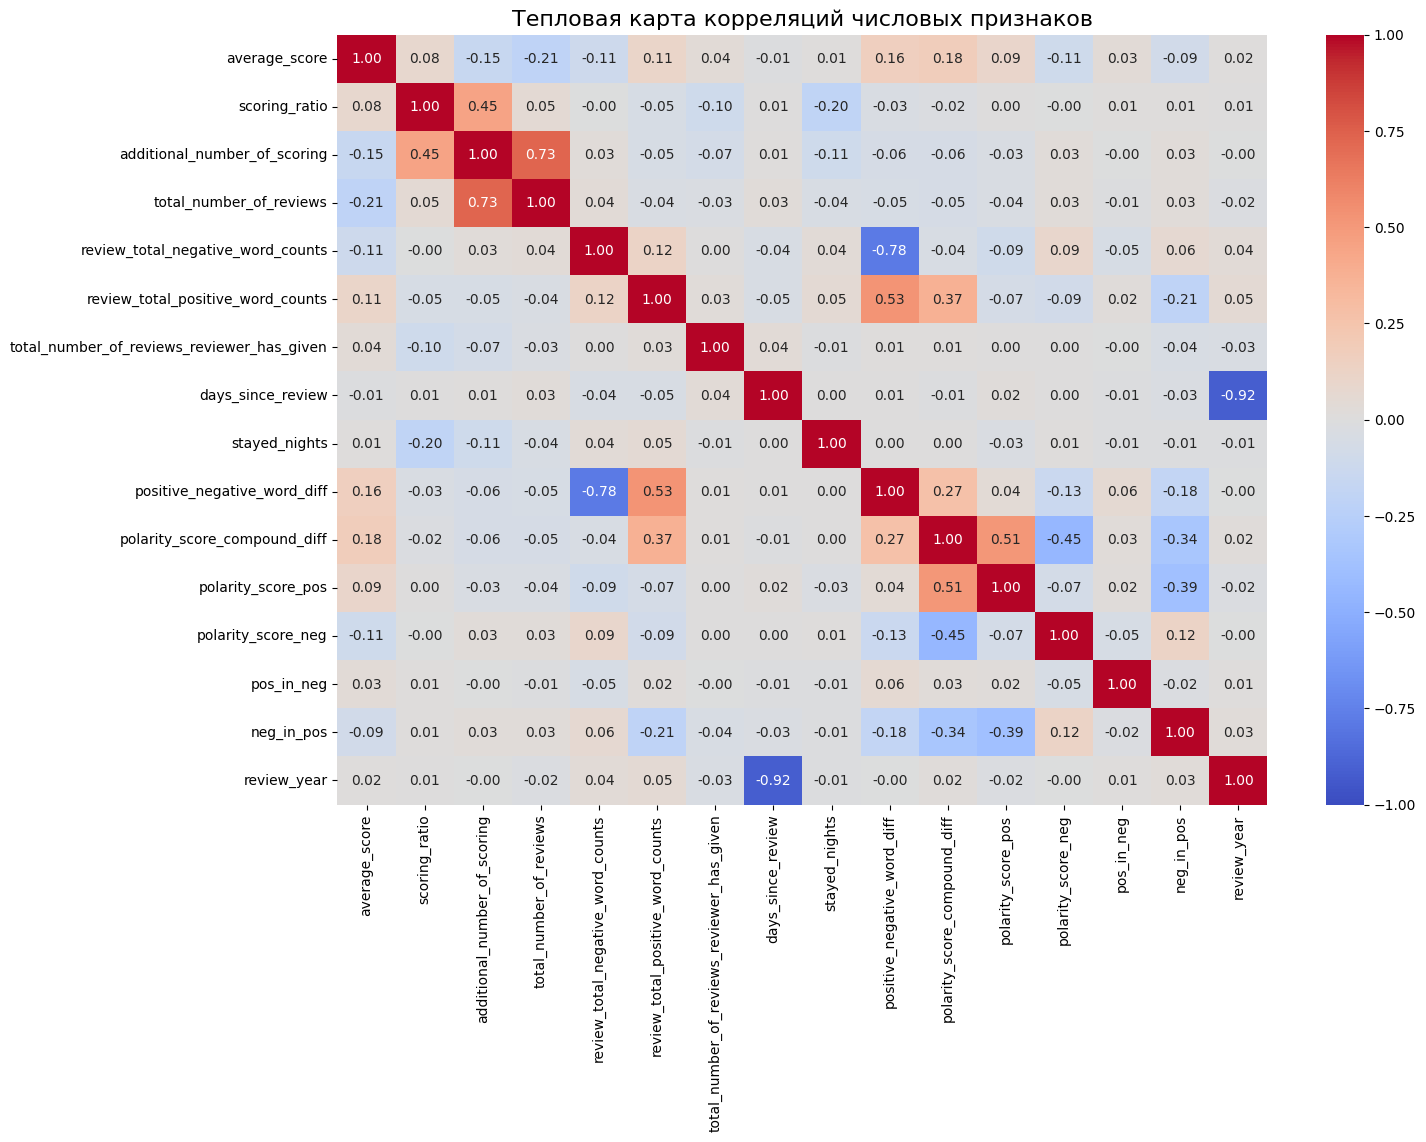

In [46]:
# Корреляционная матрица для числовых признаков
# (анализ проводим на совмещенном трейн и тест датасетах)

# Установим размеры графика
plt.figure(figsize=(15, 10))

# Рассчитаем матрицу коллинеарности методом Пирсона
num_corr_mtx = data[num_cols].corr()

# Построим "тепловую карту"
sns.heatmap(num_corr_mtx, annot=True, fmt=".2f", cmap='coolwarm',
            vmin=-1, vmax=1)
plt.title('Тепловая карта корреляций числовых признаков', fontsize=16)

# Отобразим график
plt.show()

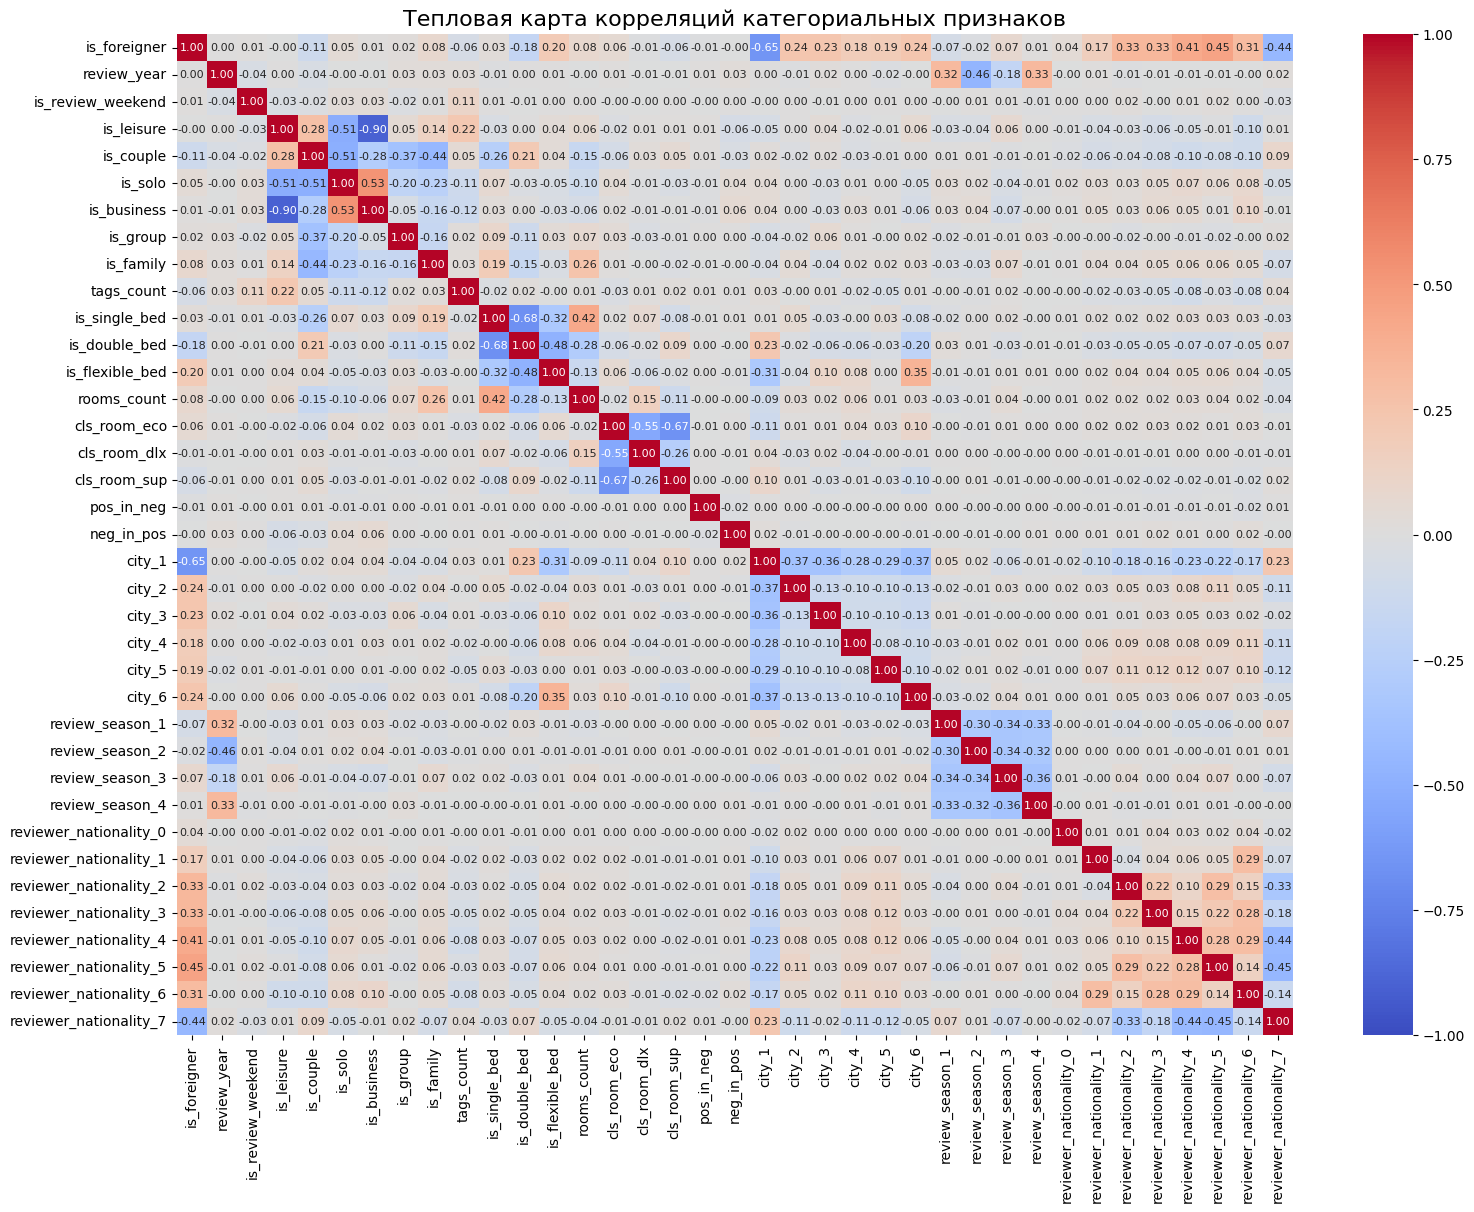

In [47]:
# Корреляционная матрица для категориальных признаков
# (анализ проводим на совмещенном трейн и тест датасетах)

# Установим размеры графика
plt.figure(figsize=(18, 13))

# Рассчитаем матрицу коллинеарности методом Спирмана
cat_corr_mtx = data[cat_cols].corr(method='spearman')

# Построим "тепловую карту"
sns.heatmap(cat_corr_mtx, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1,
            vmax=1, annot_kws={'size': 8})
plt.title('Тепловая карта корреляций категориальных признаков', fontsize=16)

# Отобразим график
plt.show()

Выявлена сильная взаимосвязь у признаков:
- *review_year* и *days_since_review*;
- *is_leisure* и *is_business*.

Дополнительная проверка показала, что удаление любого из признаков is_leisure или is_business ухудшают MAPE, поэтому удалим только days_since_review

In [48]:
# Избавимся от мультиколлинеарности review_year и days_since_review
data.drop('days_since_review', axis=1, inplace=True)

## 6. Отбор признаков на основе их важности

### 6.1. Определение важности числовых признаков (тест ANOVA)

In [49]:
# Скорректируем список числовых признаков
num_cols = num_cols[:-3]  # Отбросим последние 3 элемента списка (категориальные)
num_cols.remove('days_since_review')  # Удалим мультиколлинеарный признак

<Axes: >

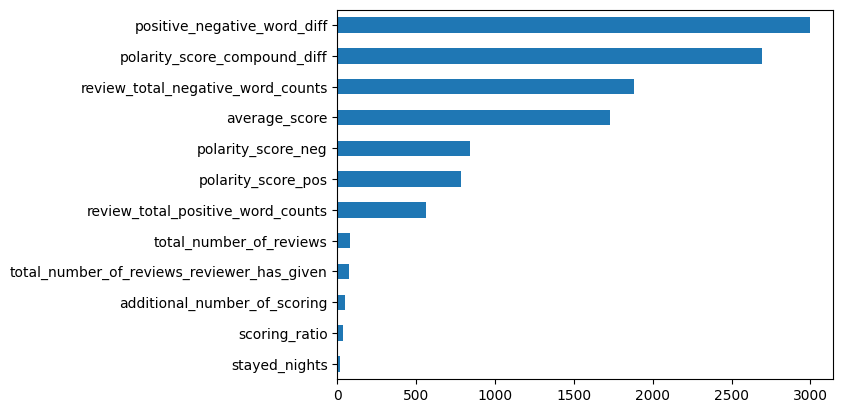

In [50]:
# Проведем тест ANOVA
imp_num = pd.Series(f_classif(data[tra_msk][num_cols],
                              data[tra_msk]['reviewer_score'])[0],
                    index = num_cols)
imp_num.sort_values(inplace = True)  # Отсортируем значения
imp_num.plot(kind = 'barh')  # Построим график

### 6.2. Определение важности категориальных признаков (тест Хи-квадрат)

<Axes: >

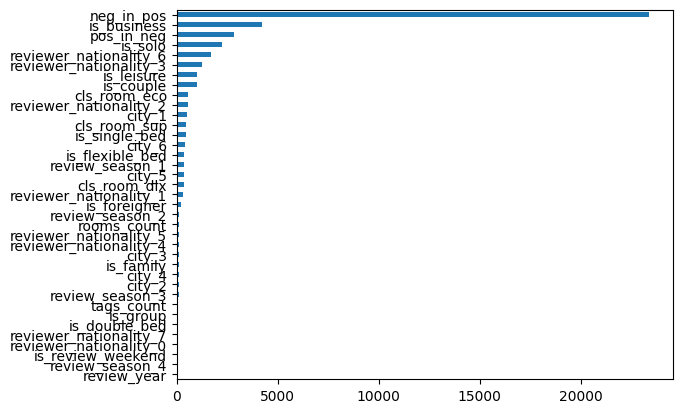

In [51]:
# Проведем тест Хи-квадрат
imp_cat = pd.Series(chi2(data[tra_msk][cat_cols],
                         data[tra_msk]['reviewer_score'].round().astype(int))[0],
                    index = cat_cols)
imp_cat.sort_values(inplace = True)  # Отсортируем значения
imp_cat.plot(kind = 'barh')  # Построим график

Суммарно получилось 12 числовых + 37 категориальных = 49 признаков + 1 целевой. На 16 потоках обучение модели занимает менее 2 мин., что является приемлемым временем. Удаление каких-либо параметров снизит метрику MAPE с понижением рейтинга в соревновании на платформе Kaggle.

С учетом вышеизложенного по временным параметрам, будем считать удаление признаков излишним.

## 7. Нормализация данных

Алгоритмы, основанные на деревьях, такие как RandomForest, не полагаются на расстояния между признаками. Вместо этого, они работают с разделением данных на основе пороговых значений, которые не зависят от масштаба признаков. В общем, для модели RandomForestRegressor нормализация или стандартизация данных не является обязательной процедурой, хотя в некоторых случаях она может быть полезна для других причин, таких как ускорение вычислений или улучшение интерпретируемости результатов. Однако, сам алгоритм RandomForest работает эффективно без предварительного масштабирования данных.

Поэтому, выполнение масштабирования или стандартизации данных в датасете при заданном алгоритме модели не является целесообразным.

## 8. Реализация машинного алгоритма и проверка его эффективности

In [52]:
# Итоговый датасет
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 51 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  float64
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   reviewer_score                              515431 non-null  float64
 7   sample                                      515431 non-null  int64  
 8   is_foreigner                                515431 non-null  int64  
 9   scoring_ratio                               515431 non-null  float64
 

In [53]:
# Выделим трейн часть с целевым признаком для обучения модели
train_data = data.query('sample == 1').drop(['sample'], axis=1)

# Выделим тестовую часть для предсказания признака для Kaggle
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values  # Целевой признак
X = train_data.drop(['reviewer_score'], axis=1)

In [54]:
# Воспользуемся специальной функцией train_test_split для разбивки трейн части 
# на трейн и тест в пропорции 80%/20% соответственно для обучения и проверки
# качества модели
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [55]:
# Проверим корректность размеров сформированных датафреймов
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 50), (386496, 50), (386496, 49), (309196, 49), (77300, 49))

In [56]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, 
                              random_state=RANDOM_SEED)

In [57]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.0s finished


In [58]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим 
# насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение 
# предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю
# абсолютную процентную ошибку предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8701337546972214
MAPE: 0.12399199306479573


```
История изменения MAPE:

MAPE: 0.13530653137320078
MAPE: 0.1270150456949572 (+polarity_weigth_diff)
MAPE: 0.1269105930455965 (удаление lat и lng)
MAPE: 0.12688378459527772 (rooms_count перекодирован на категории)
MAPE: 0.12689948488196898 (hotel_distance_rating - 3 km) (-)
MAPE: 0.12582154753519312 (введены еще 2 признака polarity)
MAPE: 0.12489472467589542 (negative_review очистка от неинформативных значений и positive_in_negative)
MAPE: 0.12473470653208653 (pos_in_neg - признак наличия 'positive in negative')
MAPE: 0.12470018572868552 (positive_in_negative add phrase)
MAPE: 0.12403572108604129 (positive_review очистка от неинформативных значений и negative_in_positive)
MAPE: 0.12403851825515272 (-days_since_review, +is_business) (+)
MAPE: 0.12406107381492451 (-days_since_review, -is_business)
MAPE: 0.12408644587208423 (+days_since_review, -is_business)
MAPE: 0.12408665511222894 (+days_since_review, +is_business) на Kaggle MAPE 12.52088
MAPE: 0.12399199306479573 (-days_since_review, +is_business, +scoring_ratio) на Kaggle MAPE 12.51912

MAPE: 0.10457988862418013 (удаление выбросов из целевого признака) на Kaggle MAPE 13.19428 (-)
MAPE: 0.10400901859015096 (удаление выбросов из целевого признака и average_score в трейн части) на Kaggle MAPE 13.23682 (-)
```

<Axes: >

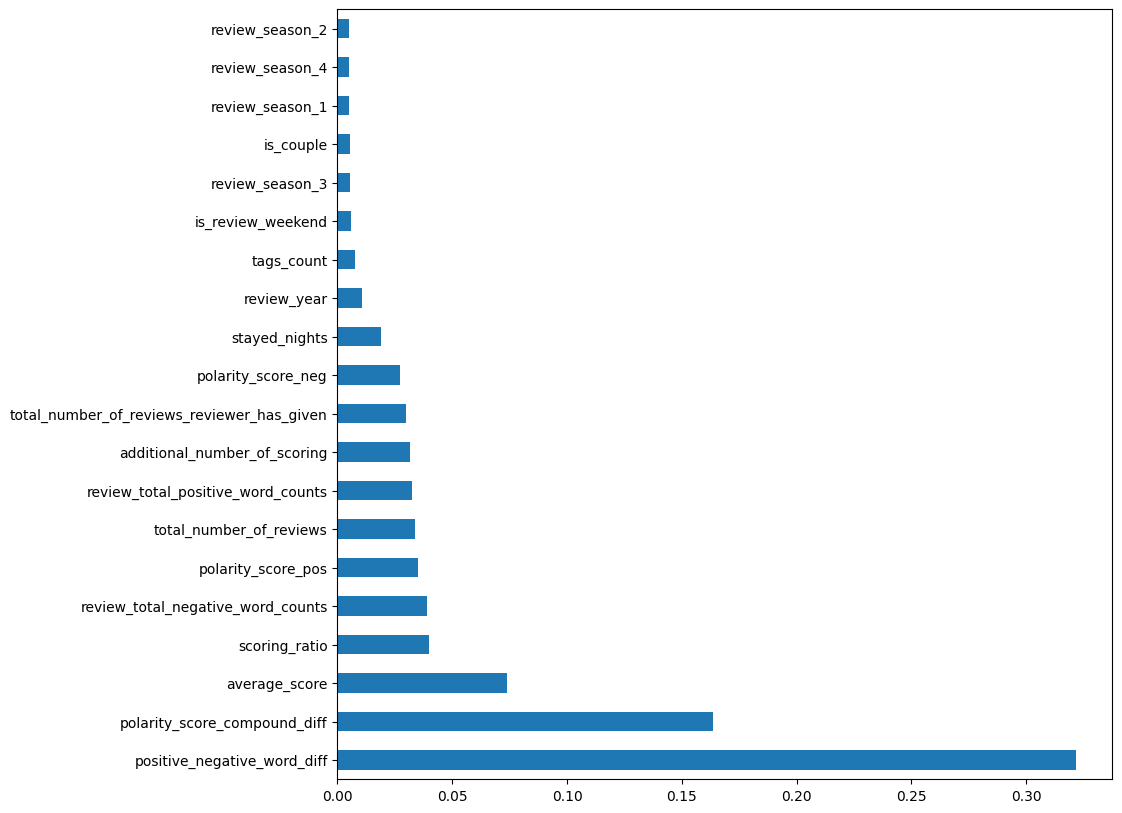

In [59]:
# Отобразим ТОП-20 самых важных признаков средствами обученной модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [60]:
# Отобразим случайные 10 строк тест датасета (для платформы Kaggle)
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,is_foreigner,scoring_ratio,review_year,...,review_season_3,review_season_4,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
501955,275,8.6,19,7.293018,9,10,0.0,0,0.187075,2016,...,0,0,0,0,0,0,0,0,0,1
494401,89,8.6,0,6.326149,32,1,0.0,1,0.159213,2016,...,0,1,0,0,0,0,1,1,0,0
400836,2623,8.7,14,9.405743,2,3,0.0,0,0.215743,2015,...,0,0,0,0,0,0,0,0,0,1
407332,568,8.6,0,7.430114,29,5,0.0,1,0.336892,2015,...,0,0,0,0,0,0,1,0,1,1
425388,105,8.2,6,6.635947,5,20,0.0,1,0.137795,2015,...,0,0,0,0,0,0,1,1,1,1
494410,241,8.6,3,7.297768,8,1,0.0,1,0.163169,2016,...,1,0,0,0,0,0,1,1,0,0
507181,444,7.0,14,7.630947,30,2,0.0,0,0.215429,2016,...,0,0,0,0,0,0,0,0,0,1
496848,834,9.1,0,8.452548,17,10,0.0,1,0.177939,2015,...,0,0,0,0,1,0,0,1,0,0
435835,61,8.7,0,6.251904,6,28,0.0,1,0.117534,2016,...,0,0,0,0,1,1,0,0,0,1
489456,452,7.6,9,7.848543,22,8,0.0,0,0.176425,2016,...,1,0,0,0,0,0,0,0,0,1


In [61]:
# Удалим пустой целевой признак из тестового датасета (нужно его предсказать)
test_data = test_data.drop(['reviewer_score'], axis=1)

In [62]:
# Пример итогового датасета
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [63]:
# Выполним предсказание целевого признака для платформы Kaggle
predict_submission = model.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.5s finished


In [64]:
# Удостоверимся в получении результата предсказания целевого признака
predict_submission

array([8.562, 7.297, 8.236, ..., 7.934, 9.674, 7.413])

In [65]:
# Округлим значения целевого признака
predict_submission_rounded = [round(_, 1) for _ in predict_submission]
# Проверим
predict_submission_rounded[:3]

[np.float64(8.6), np.float64(7.3), np.float64(8.2)]

In [66]:
# Сохраним значения целевого признака в результирующий датафрейм
sample_submission['reviewer_score'] = predict_submission_rounded
# Сохраним в файл для загрузки на платформу Kaggle
sample_submission.to_csv('submission.csv', index=False)
# Проверим корректность значений датафрейма
sample_submission.head(10)

,reviewer_score,id
0,8.6,488440
1,7.3,274649
2,8.2,374688
3,9.7,404352
4,9.6,451596
5,8.6,302161
6,8.3,317079
7,7.8,13963
8,8.2,159785
9,8.0,195089


## 9. Выводы

На основе представленных в дата-сете данных (по данным сайта *Booking*) была создана модель, которая предсказывает рейтинг отеля.

Проект состоит из следующих последовательных блоков:
- Инициализация и загрузка данных, предварительное знакомство с данными;
- Описательный анализ и очистка даных от дубликатов и пропущенных значений;
- Визульный анализ данных с предварительными выводами;
- Преобразование и создание новых признаков;
- Кодирование признаков;
- Анализ мультиколлинеарности числовых и категориальных признаков;
- Отбор признаков на основе их важности (отбор произведен, но оставлены все признаки для улучшения метрики **MAPE**);
- Нормализация данных (не выполнялась по причине отсутствия целесообразности);
- Реализация машинного алгоритма и проверка его эффективности;
- Выгрузка данных для платформы Kaggle (submission.csv).
___
В процессе работы над проектом были закреплены методы анализа и манипуляции с данными в рамках **EDA**, а также практическая реализация **Feature Engineering**.
Достаточное количество времени было уделено созданию новых признаков на основе уже существующих. Как впоследствии показал визуальный анализ и статистическое исследование на определение важности созданных признаков, некоторые из них оказывали крайне малое (на уровне погрешности вычислений) улучшение или же вообще ухудшали метрику качества **MAPE**.

Можно заметить, что визульная составляющая могла быть обширней и покрывать все созданные и преобразованные признаки. Поскольку практического смысла в этом мало (минимизация **MAPE**), основной акцент в приоритетах был смещён в блок работы *Feature Engineering*.

Из того, что можно было бы дополнительно улучшить в части *Feature Engineering*:
- Категоризация обработанного признака *days_since_review*. Возможно, что заменит *review_year* и немного улучшит **MAPE**;
- Введение нового признака, который зависит от национальности клиента. Например, среднее (или другая функция) от рейтинга отелей, сгруппированного по признаку национальности. Это позволит выделить культурные и региональные особенности, национальные предпочтения и, возможно, немного улучшит **MAPE**;
- Признак *total_number_of_reviews_reviewer_has_given* вместе с признаком национальности позволит с достаточно большой степенью вероятности идентифицировать клиента с введением персонального признака этого клиента. Теоретически, это должно немного улучшить **MAPE**;
- Пересмотр алгоритма расчета туристического рейтинга отеля (обозначенные в **п. 3.5** способы *пп. 2,3* были реализованы и отключены из-за ухудшения **MAPE**);
- Расширенный анализ позитивных и негативных комментариев. Например: *TF-IDF* и/или *word embeddings*, семантические модели *BERT* вместо использованной *VADER*.

>Стоит отдельно отметить, что для задачи минимизации **MAPE** выбранный алгоритм, основанный на "случайных деревьях", может быть не совсем оптимальным и лучше отдельно подбирать наиболее подходящую модель вручную или же использовать универсальные библиотеки с авто-подбором наиболее оптимальной модели (например, *LightAutoML*).

Исходя из анализа признаков на основе их важности очевидно, что основное внимание нужно уделить последнему обозаченному пункту, а именно: расширенная обработка позитивных и негативных комментариев. В теории, это должно довольно сильно улучшить метрику **MAPE**.

С учетом того, что данные методы относятся к отдельной области **NLP** и некоторые из них (например, основанные на архитектуре *Transformer* модели *BERT*) по сложности превзойдут данный проект на несколько порядков, а также основного акцента данного проекта на закрепление методов работы с данными в контексте блока *EDA + Feature Engineering*, а не цели победы на платформе Kaggle (итоговый **MAPE: 12.51912**), можно считать, что основная цель данного проекта достигнута.